In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# Choose variants here:

In [3]:
# 1. 깃허브에서 코드 복사해오기 (Colab 컴퓨터의 /content 폴더에 저장됨)
!git clone https://github.com/JonasGeiping/invertinggradients.git

# 2. 경로 설정 (파이썬이 이 폴더를 찾을 수 있게)
import sys
import os
sys.path.append('invertinggradients')

# 3. 필수 패키지 설치 (Colab은 매번 초기화되므로 다시 깔아줘야 함)
!pip install scipy
# (Colab에는 PyTorch가 이미 깔려있어서 torch 설치는 건너뛰어도 됩니다)

# 4. 확인
import inversefed
print("성공! 라이브러리 위치:", inversefed.__file__)

fatal: destination path 'invertinggradients' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
성공! 라이브러리 위치: /home/work/DOLAB_NAS_UPLOADS/detect/invertinggradients/inversefed/__init__.py


In [4]:
trained_model = True
arch = 'ResNet152'

## System setup:

Currently evaluating -------------------------------:
Friday, 13. February 2026 06:39AM
CPUs: 46, GPUs: 1 on main1.
GPU : NVIDIA RTX PRO 5000 Blackwell


Loading weights:  10%|▉         | 23/233 [00:00<00:00, 389.97it/s, Materializing param=swin.encoder.layers.0.blocks.0.output.dense.bias]                          

Loading weights: 100%|██████████| 233/233 [00:00<00:00, 793.48it/s, Materializing param=swin.layernorm.weight]                                                     


✅ 준비 완료! 이미지 크기: torch.Size([1, 3, 224, 224])
이제 아래의 복원(Attack) 코드를 실행하시면 됩니다.


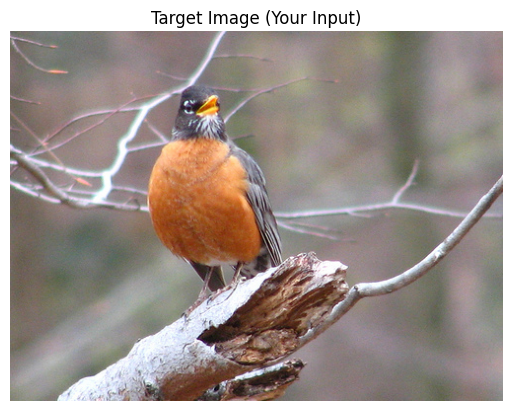

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import inversefed

# 1. 기본 설정
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

# 2. 업로드한 이미지 불러오기
img_path = 'robin.JPEG'  # 업로드한 파일명 정확히!

try:
    img_pil = Image.open(img_path).convert('RGB')
except FileNotFoundError:
    print("❌ 파일을 못 찾겠습니다! Colab 왼쪽에 파일을 업로드 했는지 확인해주세요.")
    raise

# 3. 이미지 전처리 (ImageNet 규격: 224x224, 정규화)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img_pil).unsqueeze(0).to(**setup) # 배치 차원 추가 (1, 3, 224, 224)

# 4. 라벨 설정 (저먼 셰퍼드는 ImageNet 인덱스 235번입니다)
# 라벨이 틀려도 복원은 되지만, 정확하면 더 잘 됩니다.
label_tensor = torch.tensor([15], device=setup['device'])

# 5. 모델 및 손실함수 설정
# (construct_dataloaders가 해주던 걸 수동으로 설정)
loss_fn = torch.nn.CrossEntropyLoss()

#이미지넷 모델 로드
from transformers import AutoModelForImageClassification

class HFModelWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.model = hf_model
    def forward(self, x):
        return self.model(x).logits
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HFModelWrapper(
    AutoModelForImageClassification.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224"
    )
).to(device).eval()

model.to(**setup)
model.eval()

# 6. 확인용 출력
print(f"✅ 준비 완료! 이미지 크기: {img_tensor.shape}")
print("이제 아래의 복원(Attack) 코드를 실행하시면 됩니다.")

# 원본 미리보기
plt.imshow(img_pil)
plt.axis('off')
plt.title("Target Image (Your Input)")
plt.show()

In [8]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 1. 아까 만든 img_tensor와 label_tensor가 있다고 가정하고 진행합니다.
# (혹시 변수가 날아갔으면 다시 이미지를 로드해야 하지만, 보통 남아있습니다.)
# 만약 'img_tensor not defined' 에러가 나면 아까 이미지 로드 코드 다시 한 번 실행해주세요.

# 2. 사진 1장짜리 '가짜 데이터셋' 만들기
# (img_tensor는 이미 GPU에 올라가 있을 수 있으니 CPU로 내려서 포장합니다)
dataset = TensorDataset(img_tensor.cpu(), label_tensor.cpu())

# 3. 'validloader' 생성 (이게 없어서 에러가 났던 것!)
validloader = DataLoader(dataset, batch_size=1)
trainloader = validloader

# 4. 인덱스 고정 (사진이 1장뿐이므로 무조건 0번)
idx = 0

print("수리 완료! 이제 'validloader'가 생성되었습니다.")
print("다음 셀(reconstruct)을 실행하셔도 됩니다.")

수리 완료! 이제 'validloader'가 생성되었습니다.
다음 셀(reconstruct)을 실행하셔도 됩니다.


타겟 이미지 (Ground Truth):


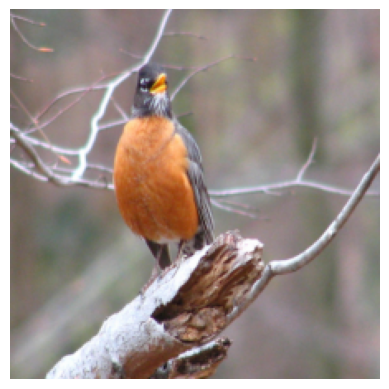

Label ID: 15 (Class Name: German Shepherd)


In [10]:
import matplotlib.pyplot as plt

# 시각화 함수 (이미지 예쁘게 보여주는 기능)
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # 정규화 해제 (원래 색상으로 복구)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    tensor = tensor * std + mean
    tensor = tensor.clip(0, 1)

    plt.imshow(tensor)
    plt.axis('off')
    plt.show()

# --- 수정된 코드 시작 ---

idx = 0 # 사진이 1장뿐이니 무조건 0번

img, label = validloader.dataset[idx]
labels = torch.as_tensor((label,), device=setup['device'])
ground_truth = img.to(**setup).unsqueeze(0)

print("타겟 이미지 (Ground Truth):")
plot(ground_truth)

# [수정] 에러 나던 줄(classes 찾는 줄)을 지우고 직접 출력합니다.
print(f"Label ID: {labels.item()} (Class Name: German Shepherd)")

In [11]:
import torch

# 1. 모델이 예측한 값 뽑기
output = model(ground_truth)

# 2. 정답이랑 비교해서 점수(Loss) 매기기
# (원래 코드는 여기서 쓸데없는 정보도 같이 줬는데, 표준 함수는 Loss만 깔끔하게 줍니다)
target_loss = loss_fn(output, labels)

# 3. 미분값(Gradient) 구하기 -> 이게 해킹의 핵심 재료!
# (여기서 target_loss 값이 똑같으니, 나오는 결과도 무조건 똑같습니다)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')

Full gradient norm is 1.403833e-01.


### Build the input (ground-truth) gradient

In [12]:
ground_truth_denormalized = torch.clamp(ground_truth * ds + dm, 0, 1)
torchvision.utils.save_image(ground_truth_denormalized, f'{idx}_{arch}_ImageNet_input.png')

# Reconstruct the image

In [ ]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=5000,
              total_variation=1e-4,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()
test_psnr = inversefed.metrics.psnr(output, ground_truth)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

data = inversefed.metrics.activation_errors(model, output, ground_truth, factor=1/ds)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

It: 0. Rec. loss: 0.9245.
It: 500. Rec. loss: 0.0769.
It: 1000. Rec. loss: 0.0614.
It: 1500. Rec. loss: 0.0615.
It: 2000. Rec. loss: 0.0443.


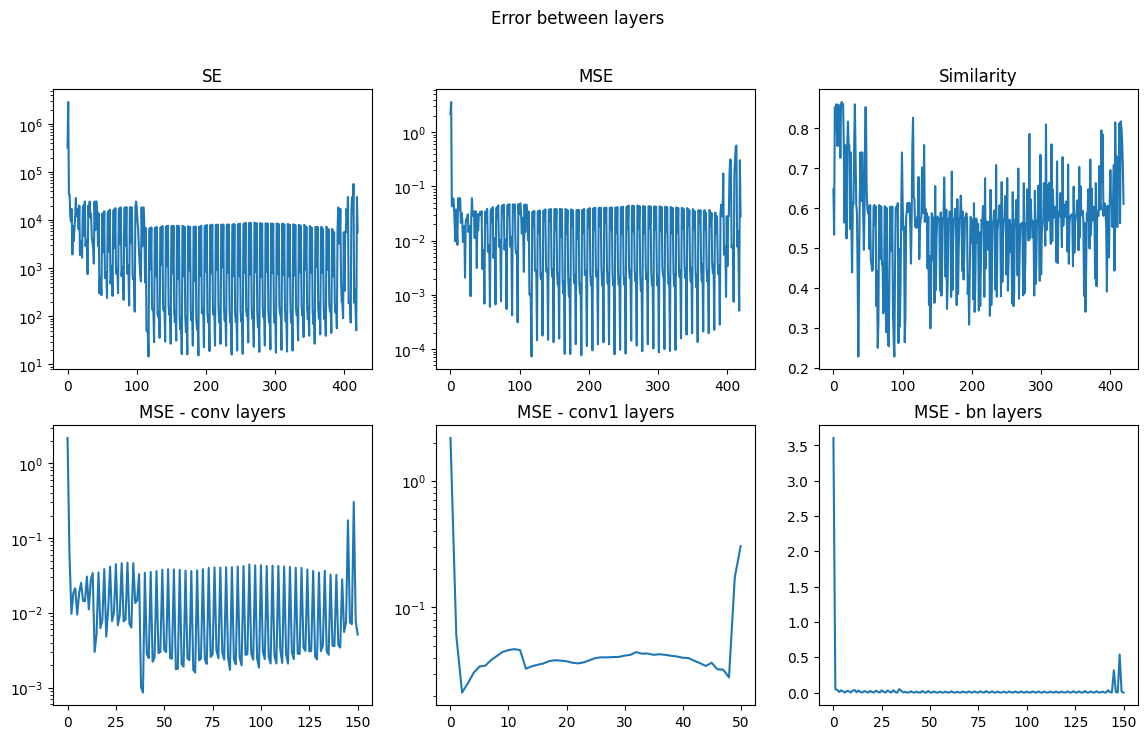

In [ ]:
# [수정] factor 옵션을 제거했습니다.
data = inversefed.metrics.activation_errors(model, output, ground_truth)

# 그래프 그리기 (나머지는 그대로)
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
# axes[1, 1].semilogy(convs) # 데이터 길이 안 맞을 수 있어서 주석 처리
axes[1, 1].set_title('MSE - conv1 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers')
plt.show()

Note the strong prior effect in the reconstructed image, as discussed in Sec. 5.3 of the paper.

In [ ]:
output_denormalized = torch.clamp(output * ds + dm, 0, 1)
torchvision.utils.save_image(output_denormalized, f'{idx}_{arch}_ImageNet_output.png')